In [1]:
import matplotlib.pyplot as plot

In [2]:
import cv2

In [3]:
import pandas
import math

In [4]:
import scipy

In [5]:
from copy import deepcopy

In [6]:
segmented_word_path = "C:\Users\Bolanle Esther\PycharmProjects\cheque\word_segmentation_results\data_6.png"

read the image

In [7]:
image_of_word = cv2.imread(segmented_word_path)

then display the image

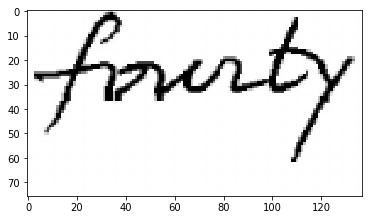

In [8]:
plot.imshow(image_of_word)
plot.show()

In [9]:
image_of_word.shape

(76L, 137L, 3L)

In [10]:
benchmark_black = [65, 65, 65]

In [11]:
def calculate_stroke_width(image): 
    #each row of pixels 
    all_stroke_widths = []
    all_stroke_locations = []
    for row_index, row in enumerate(image):
        running_stroke = False
        current_width = 0
        pixel_indices = []
        for column_index, column in enumerate(row): 
            if (column[0] <= benchmark_black[0] and column[1] <= benchmark_black[1] and column[2] <= benchmark_black[2]):
                running_stroke = True
                current_width = current_width + 1
                pixel_indices.append((row_index, column_index))
            else: 
                if(current_width > 0):
                    all_stroke_widths.append(current_width)
                    all_stroke_locations.append(deepcopy(pixel_indices))
                    current_width = 0
                    pixel_indices = []
                running_stroke = False
        if(current_width > 0):
            all_stroke_widths.append(current_width)
            all_stroke_locations.append(deepcopy(pixel_indices))
            current_width = 0
    return all_stroke_widths, all_stroke_locations
                    
all_stroke_widths, all_stroke_width_locations = calculate_stroke_width(image_of_word)

In [12]:
 all_stroke_widths = pandas.DataFrame(all_stroke_widths)

In [13]:
mean_stroke = all_stroke_widths.mean()[0]

In [14]:
#now calculate the length-wise stroke
def calculate_stroke_height(image): 
    all_stroke_height = []
    all_stroke_locations = []
    for column_index in range(0, (image.shape[1])): #loop through each column
        running_stroke = False
        current_height = 0
        pixel_indices = []
        column = image[:,column_index]
        for row_index in enumerate(column): 
            if (column[0] <= benchmark_black[0] and column[1] <= benchmark_black[1] and column[2] <= benchmark_black[2]):
                running_stroke = True
                current_height = current_height + 1
                pixel_indices.append((row_index, column_index))
            else: 
                if(current_height > 0):
                    all_stroke_height.append(current_height)
                    all_stroke_locations.append(deepcopy(pixel_indices))
                    current_height = 0
                    pixel_indices = []
                running_stroke = False
        if(current_height > 0):
            all_stroke_height.append(current_width)
            all_stroke_locations.append(deepcopy(pixel_indices))
            current_height = 0
    return all_stroke_height, all_stroke_locations
                    
all_stroke_height, all_stroke_height_locations = calculate_stroke_width(image_of_word)

In [15]:
#get row with the max number of strokes as the row that represent roughly the one that has all the characters
def calculate_row_with_max_separate_stokes(image): 
    #each row of pixels 
    max_strokes= -1
    max_strokes_index = -1
    for row_index, row in enumerate(image):
        running_stroke = False
        number_of_indv_strokes = 0
        for column_index, column in enumerate(row): 
            if (column[0] <= benchmark_black[0] and column[1] <= benchmark_black[1] and column[2] <= benchmark_black[2]):
                running_stroke = True
            else: 
                if running_stroke:
                    number_of_indv_strokes = number_of_indv_strokes + 1
                running_stroke = False
        if(number_of_indv_strokes > max_strokes):
            max_strokes = number_of_indv_strokes
            max_stroke_index = row_index
    return max_stroke_index
max_stroke_index = calculate_row_with_max_separate_stokes(image_of_word)

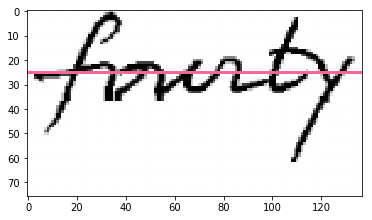

In [16]:
#visualise the row with the most strokes
image_for_visuals = deepcopy(image_of_word)
image_for_visuals[max_stroke_index] = [[250, 100, 154] for pixel in image_for_visuals[max_stroke_index]]
plot.imshow(image_for_visuals)
plot.show()

In [17]:
#we only want those strokes less than within 1 pixel of the mean as candidates to search from 
def prune_for_candidate_search(image) :
    row_with_most_strokes = image[max_stroke_index]
    row_with_most_strokes_widths_and_locations = [] 
    pruned_strokes = []
    pixel_indices = []
    current_stroke_width = 0
    for column_index, column in enumerate(row_with_most_strokes): 
            if (column[0] <= benchmark_black[0] and column[1] <= benchmark_black[1] and column[2] <= benchmark_black[2]):
                running_stroke = True
                current_stroke_width = current_stroke_width + 1
                pixel_indices.append((max_stroke_index, column_index))
            else: 
                if(current_stroke_width > 0):
                    row_with_most_strokes_widths_and_locations.append((current_stroke_width, deepcopy(pixel_indices)))
                    current_stroke_width = 0
                    pixel_indices = []
                running_stroke = False
    if(current_stroke_width > 0):
        row_with_most_strokes_widths_and_locations.append((current_stroke_width, deepcopy(pixel_indices)))
        current_width = 0
    for candidate_stroke in row_with_most_strokes_widths_and_locations:
        #if candidate_stroke[0] >= mean_stroke - 1 and candidate_stroke[0] <= mean_stroke + 1:
        pruned_strokes.extend(candidate_stroke[1])
    
    return pruned_strokes
strokes_pruned = prune_for_candidate_search(image_of_word)

In [36]:
#now we need to get the lowest pixels for each of the strokes - we use a depth first search downwards 
def find_lowest_pixels(unvisited_pixels, image) : 
    visited_pixels = [] 
    unvisited_pixels.reverse()
    lowest_pixels = []
    while len(unvisited_pixels) > 0: 
        current_pixel = unvisited_pixels.pop()
        visited_pixels.append(current_pixel)
        
        bottom_left = (current_pixel[0] + 1, current_pixel[1] - 1)
        bottom_middle = (current_pixel[0] + 1, current_pixel[1])
        bottom_right = (current_pixel[0] + 1, current_pixel[1] + 1)
        added_children = False
        if (bottom_left not in visited_pixels and bottom_left[0] < image.shape[0] and bottom_left[1] < image.shape[1] and 
            image[bottom_left][0] <= benchmark_black[0] and image[bottom_left][1] <= benchmark_black[1] and
            image[bottom_left][2] <= benchmark_black[2]):
                unvisited_pixels.append(bottom_left)
                added_children = True
                
        if (bottom_middle not in visited_pixels and bottom_middle[0] < image.shape[0] and bottom_middle[1] < image.shape[1] and 
            image[bottom_middle][0] <= benchmark_black[0] and image[bottom_middle][1] <= benchmark_black[1] and
            image[bottom_middle][2] <= benchmark_black[2]):
                unvisited_pixels.append(bottom_middle)
                added_children = True
                
        if (bottom_right not in visited_pixels and bottom_right[0] < image.shape[0] and bottom_right[1] < image.shape[1] and 
            image[bottom_right][0] <= benchmark_black[0] and image[bottom_right][1] <= benchmark_black[1] and
            image[bottom_right][2] <= benchmark_black[2]):
                unvisited_pixels.append(bottom_right)
                added_children = True
        
        if not added_children:
            lowest_pixels.append(current_pixel)
        
    return lowest_pixels

lowest_points = find_lowest_pixels(deepcopy(strokes_pruned), image_of_word)

In [37]:
#now we need to get the highest pixels for each of the strokes - we use a depth first search highest 
def find_highest_pixels(unvisited_pixels, image) : 
    visited_pixels = [] 
    unvisited_pixels.reverse()
    highest_pixels = []
    while len(unvisited_pixels) > 0: 
        current_pixel = unvisited_pixels.pop()
        visited_pixels.append(current_pixel)
        
        top_left = (current_pixel[0] - 1, current_pixel[1] - 1)
        top_middle = (current_pixel[0] - 1, current_pixel[1])
        top_right = (current_pixel[0] - 1, current_pixel[1] + 1)
        added_children = False
        if (top_left not in visited_pixels and top_left[0] < image.shape[0] and top_left[1] < image.shape[1] and 
            image[top_left][0] <= benchmark_black[0] and image[top_left][1] <= benchmark_black[1] and
            image[top_left][2] <= benchmark_black[2]):
                unvisited_pixels.append(top_left)
                added_children = True
                
        if (top_middle not in visited_pixels and top_middle[0] < image.shape[0] and top_middle[1] < image.shape[1] and 
            image[top_middle][0] <= benchmark_black[0] and image[top_middle][1] <= benchmark_black[1] and
            image[top_middle][2] <= benchmark_black[2]):
                unvisited_pixels.append(top_middle)
                added_children = True
                
        if (top_right not in visited_pixels and top_right[0] < image.shape[0] and top_right[1] < image.shape[1] and 
            image[top_right][0] <= benchmark_black[0] and image[top_right][1] <= benchmark_black[1] and
            image[top_right][2] <= benchmark_black[2]):
                unvisited_pixels.append(top_right)
                added_children = True
        
        if not added_children:
            highest_pixels.append(current_pixel)
        
    return highest_pixels

highest_points = find_highest_pixels(deepcopy(strokes_pruned), image_of_word)

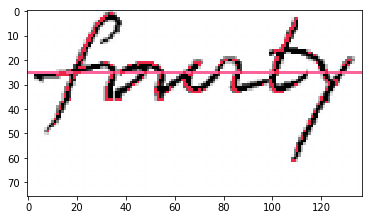

In [38]:
#draw this so we can visualise
def visualise_points( all_points, image):
    for point in all_points: 
        image[point] = [235, 38, 70]
    plot.imshow(image)
    plot.show()

    
all_points = []
all_points.extend(lowest_points)
all_points.extend(highest_points)
visualise_points(all_points, image_for_visuals)

In [24]:
def follow_east_and_segment(highest_points, lowest_points, image):
    
    

IndentationError: expected an indented block (<ipython-input-24-d707d2f00c5c>, line 4)